<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/dim_reduction/ADMET_data_distribution_10_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install molvs --quiet

In [5]:
import shutil
# path_prev = '/content/t-SNE/'
# new_path = shutil.move(path_prev, '/content/drive/MyDrive/ADMET/')
# print(new_path)
# temp/dir2/subdir

In [ ]:
# shutil.rmtree('/content/drive/MyDrive/ADMET/t-SNE')

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

In [7]:
# from scripts.preprocess_mols import preprocess, rename_cols, clean_mol, scal

from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
import numpy as np
from tqdm import tqdm
from molvs.normalize import Normalizer, Normalization
from molvs.charge import Reionizer, Uncharger

from rdkit import RDLogger
import warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")

def preprocess(smi):
    "Reference: https://github.com/Yimeng-Wang/JAK-MTATFP/blob/main/preprocess.py"
    try:
        mol = Chem.MolFromSmiles(smi)
        normalizer = Normalizer()
        new1 = normalizer.normalize(mol)
        remover = SaltRemover()
        new2 = remover(new1)
        neutralize1 = Reionizer()
        new3 = neutralize1(new2)
        neutralize2 = Uncharger()
        new4 = neutralize2(new3)
        new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
        if new4!=None: return new_smiles
        else: return None
    except: return None

def rename_cols(df, name): return df.rename(columns={'Y':name})

def clean_mol(df:pd.DataFrame):
    prev_len = len(df)
    drop_idxs = []
    for i in tqdm(range(len(df)), total=len(df), desc='Cleaning mols'):
        try:
            df.iloc[i]['Drug'] = preprocess(df.iloc[i]['Drug'])
            if pd.isna(df.iloc[i]['Drug']) or df.iloc[i]['Drug']==None:
                drop_idxs.append(i)
        except: drop_idxs.append(i)
    for i in drop_idxs: df = df.drop(i)
    if len(df) != prev_len: print(f'prev len: {prev_len}; after clean: {len(df)}')
    try: assert df['Drug'].isnull().values.any() == False
    except: print('There are nan in Drug column')
    return df.reset_index(drop=True)

def scal(df, min_here=None, max_here=None): # min max scaling
    # df_norm = df.loc[:, df.columns!='Drug'].copy()
    df_norm = df.copy()
    for col in df_norm.columns:
        if col == 'Drug': pass
        else:
            if min_here == None or max_here == None:
                min_here = df_norm[col].min()
                max_here = df_norm[col].max()
            df_norm[col] = (df_norm[col]-min_here
            )/(max_here - min_here) * 10 + 1e-3
    # df_norm['Drug'] = df['Drug']
    return df_norm

from tdc.single_pred import ADME
def collect_data(names:list, IS_R, SCALE=False, type_tdc='ADME'):
    for i, name in enumerate(names):
        print('*'*15, name, '*'*15)
        if type_tdc == 'ADME':
            data = ADME(name=name)
            # data.label_distribution()
            split = data.get_split()
        train, valid = clean_mol(split['train']), clean_mol(split['valid'])
        test =  clean_mol(split['test'])

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if IS_R and SCALE: train, valid, test = scal(train), scal(valid), scal(test)

        if i == 0: trains, valids, tests = train, valid, test
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')
    return trains, valids, tests


In [8]:
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list

label_list = retrieve_label_name_list('herg_central')

def collect_data_10_24(names:list, clean_mol_=False, show_dist=True):

    names_ADME = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
              'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB',
              'CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
              'CYP1A2_Veith', 'CYP2C9_Veith', 'BBB_Martins',
              'Bioavailability_Ma', 'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS']

    for i, name in enumerate(names):
        # print('*'*15, name, '*'*15)
        if name in label_list:
            data = Tox(name='herg_central', label_name=name)
        else:
            if name in names_ADME: data = ADME(name=name)
            else:
                try: data = Tox(name=name)
                except: print('cannot read data!'); return
            if show_dist: data.label_distribution()
        split = data.get_split()
        train, valid, test = split['train'], split['valid'], split['test']
        if clean_mol_:
            train, valid, test = clean_mol(train), clean_mol(valid), clean_mol(test)

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if i == 0:
            trains, valids, tests = train.copy(), valid.copy(), test.copy()
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')

    return trains, valids, tests

# EXAMPLE CODE
# trains, valids, tests = collect_data_10_24(['Caco2_Wang'], show_dist=False)

In [9]:
import pandas as pd
from mycolorpy import colorlist as mcp
def count_(df:pd.DataFrame):
    for col in df.columns:
        if col != 'Drug':
            try:
                ones = df[col].value_counts()[1]
                zero = df[col].value_counts()[0]
            except: ones = 'Nan'; zero = 'Nan'
            print(col, f'\t 0: {zero} | 1: {ones} | total: {zero+ones}')

def scale(trains, valids, tests):
    print('scaling train valid test data set for regression task ')
    dict_scale = {}
    for col in trains.columns:
        if col == 'Drug': pass
        else:
            # print(col)
            min_here = min(trains[col].min(), valids[col].min(), tests[col].min())
            max_here = max(trains[col].max(), valids[col].max(), tests[col].max())
            dict_scale[col] = [min_here, max_here]
            delta_here = max_here - min_here
            trains[col] = (trains[col] - min_here) / delta_here
            valids[col] = (valids[col] - min_here) / delta_here
            tests[col]  = (tests[col]  - min_here) / delta_here

    return trains, valids, tests, dict_scale

In [10]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

def process(data_):
    data = data_.copy()
    # data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['Drug'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data

def make_path(path_name, verbose=True):
    import os
    if os.path.exists(path_name):
        if verbose: print('path:', path_name, 'already exists')
    else: os.makedirs(path_name); print('path:', path_name, 'is created')


In [11]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

def plot_dim_reduced(mol_info, label, task_type, dim_reduct='PCA', title=None):
    """
    param mol_info: could be MACCS Fingerprint
    param label: label of data
    param task_type: [True, False], True:regression; False: classification
    param dim_reduct" : ['PCA', 't-SNE']
    param title: None or string, the name of the plot
    Return figure.png saved at dim_reduct/title.png
    """
    features, labels = mol_info.copy(), label.copy()
    n_components = 2
    if dim_reduct == 'PCA':
        pca = PCA(n_components=n_components)
        pca.fit(features)
        features = StandardScaler().fit_transform(features)
        features = pd.DataFrame(data = pca.transform(features))
        ax_label = 'principle component'
    elif dim_reduct=='t-SNE':
        features = TSNE(n_components=n_components).fit_transform(features)
        features = MinMaxScaler().fit_transform(features)
        features = pd.DataFrame(np.transpose((features[:,0],features[:,1])))
        ax_label = 't-SNE'
    else: print("""Error! dim_reduct should be 'PCA' or 't-SNE'"""); return

    columns = [f'{ax_label} {i+1}' for i in range(n_components)]
    # features = pd.DataFrame(data = pca.transform(features), columns=columns)
    features.columns = columns
    features['label'] = labels

    sns.set_theme(style="whitegrid")
    # f, ax = plt.subplots(figsize=(6, 6))
    f, ax = plt.subplots()

    param_dict = {'x': columns[0],
                'y': columns[1],
                'hue':'label',
                'palette': 'RdBu',
                'data': features,
                's': 10,
                'ax':ax}

    # sns.despine(f, left=True, bottom=False)
    sns.scatterplot(**param_dict)

    if task_type == True: # regression task, color bar for labels
        norm = plt.Normalize(labels.min(), labels.max())
        scalarmap = plt.cm.ScalarMappable(cmap=param_dict['palette'], norm=norm)
        scalarmap.set_array([])
        ax.figure.colorbar(scalarmap)
        ax.get_legend().remove()
    else: sns.move_legend(ax, 'upper right') # for classification, label box

    ax = plt.gca()
    # Set the border or outline color and width
    border_color = 'black'
    border_width = 0.6  # Adjust this as needed

    # Add a rectangular border around the plot
    for i in ['top', 'right', 'bottom', 'left']: ax.spines[i].set_visible(True)

    for spine in ax.spines.values():
        spine.set_linewidth(border_width); spine.set_color(border_color)
    # move the legend if has that:

    if title == None: title = f'{dim_reduct}_demo'
    plt.title(title); make_path(dim_reduct, False)
    plt.savefig(f'{dim_reduct}/{title}.png', format='png', transparent=True)
    print(f'figure saved at {dim_reduct}/{title}.png')
    plt.show(); plt.close()


"""TEST CODE"""
# name = 'HIA_Hou'; IS_R = False
# # name = 'Caco2_Wang'; IS_R = True
# trains, valids, tests = collect_data_10_24([name], show_dist=False)
# df_all   = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
# data_list = [trains, valids, tests, df_all]
# desc_list = ['train set', 'valid set', 'test set', 'data set']
# for (data, desc) in zip(data_list, desc_list):
#     data = process(data)
#     features, labels = data[header], data[name]
#     assert features.shape[0] == len(labels)
#     for dim_reduct in ['PCA', 't-SNE']:
#         title = f'{dim_reduct} on {desc} of {name}'
#         if dim_reduct == 'PCA':
#             plot_dim_reduced(features, labels, IS_R, dim_reduct, title)

'TEST CODE'

## Data distribution information

https://github.com/yingzibu/MOL2ADMET/tree/main

In [12]:
names_dict = {}
names_reg = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu'] # regression task
names_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
             'CYP1A2_Veith', 'CYP2C9_Veith'] + \
            ['BBB_Martins', 'Bioavailability_Ma',
             'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS'] + \
            ['hERG_Karim', 'AMES']

for name in names_reg + names_cls:
    if name in names_reg:   names_dict[name] = True  # regression task
    elif name in names_cls: names_dict[name] = False # classification task

for name, is_r in names_dict.items():
    if is_r: ty = 'Regression'
    else: ty = 'Classification'
    print(f'{name},\t {ty} task')

Caco2_Wang,	 Regression task
Lipophilicity_AstraZeneca,	 Regression task
HydrationFreeEnergy_FreeSolv,	 Regression task
Solubility_AqSolDB,	 Regression task
LD50_Zhu,	 Regression task
CYP2C19_Veith,	 Classification task
CYP2D6_Veith,	 Classification task
CYP3A4_Veith,	 Classification task
CYP1A2_Veith,	 Classification task
CYP2C9_Veith,	 Classification task
BBB_Martins,	 Classification task
Bioavailability_Ma,	 Classification task
Pgp_Broccatelli,	 Classification task
HIA_Hou,	 Classification task
PAMPA_NCATS,	 Classification task
hERG_Karim,	 Classification task
AMES,	 Classification task


Found local copy...
Loading...
Done!


********************************************************************************
****************************** Caco2_Wang ******************************
********************************************************************************


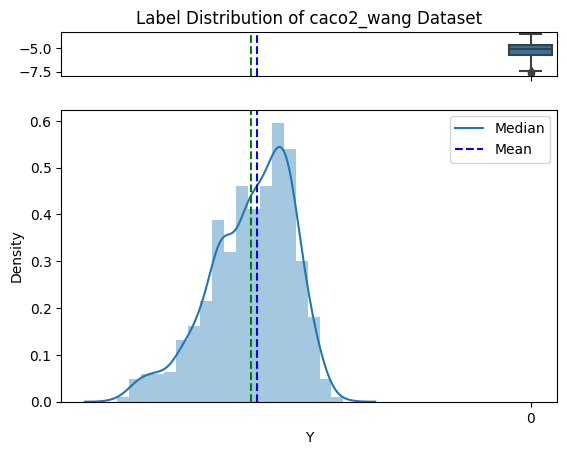

Found local copy...
Loading...
Done!


train: 637 | valid: 91 | test: 182 | total: 910
train min max:  -7.619999900000002 -3.729485
Valid min max:  -7.309999900000001 -4.02
test  min max:  -7.7600002 -3.51
scaling train valid test data set for regression task 
min, max value for all data: {'Caco2_Wang': [-7.7600002, -3.51]}




********************************************************************************
****************************** Lipophilicity_AstraZeneca ******************************
********************************************************************************


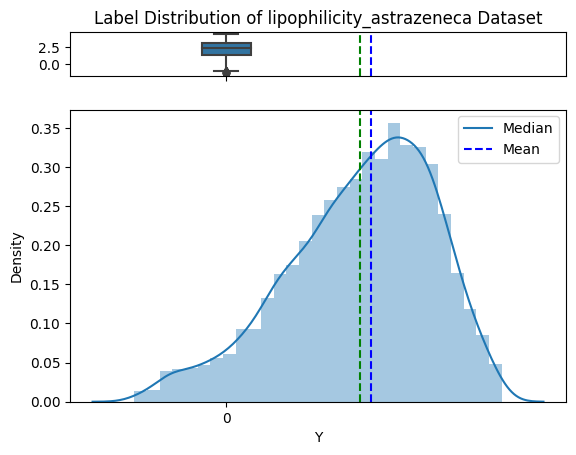

Found local copy...
Loading...
Done!


train: 2940 | valid: 420 | test: 840 | total: 4200
train min max:  -1.5 4.5
Valid min max:  -1.08 4.5
test  min max:  -1.45 4.49
scaling train valid test data set for regression task 
min, max value for all data: {'Lipophilicity_AstraZeneca': [-1.5, 4.5]}




********************************************************************************
****************************** HydrationFreeEnergy_FreeSolv ******************************
********************************************************************************


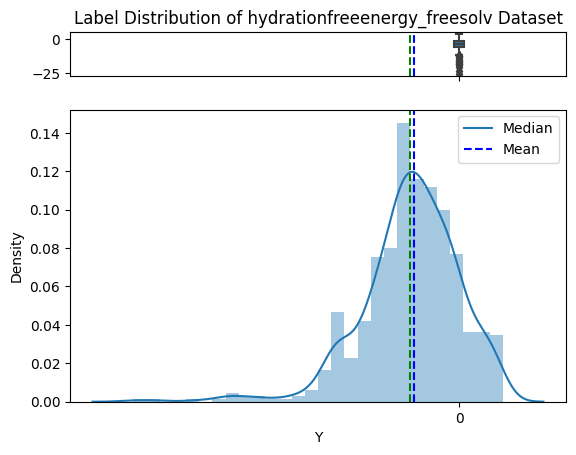

Found local copy...
Loading...
Done!


train: 450 | valid: 64 | test: 128 | total: 642
train min max:  -25.47 3.16
Valid min max:  -13.43 2.56
test  min max:  -23.62 3.43
scaling train valid test data set for regression task 
min, max value for all data: {'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]}




********************************************************************************
****************************** Solubility_AqSolDB ******************************
********************************************************************************


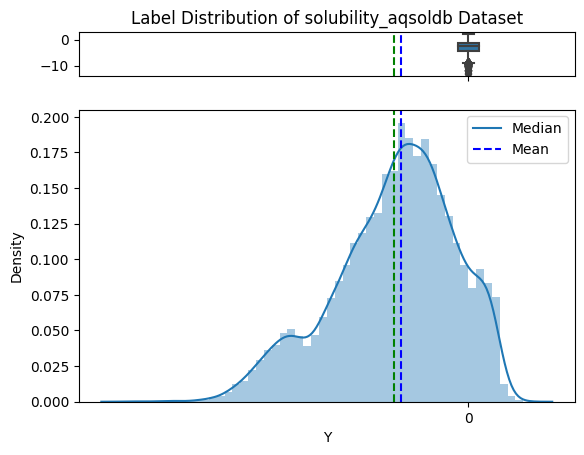

Found local copy...
Loading...
Done!


train: 6988 | valid: 998 | test: 1996 | total: 9982
train min max:  -13.1719 2.1376816201
Valid min max:  -10.6 1.5657185919
test  min max:  -12.95 1.7009159091
scaling train valid test data set for regression task 
min, max value for all data: {'Solubility_AqSolDB': [-13.1719, 2.1376816201]}




********************************************************************************
****************************** LD50_Zhu ******************************
********************************************************************************


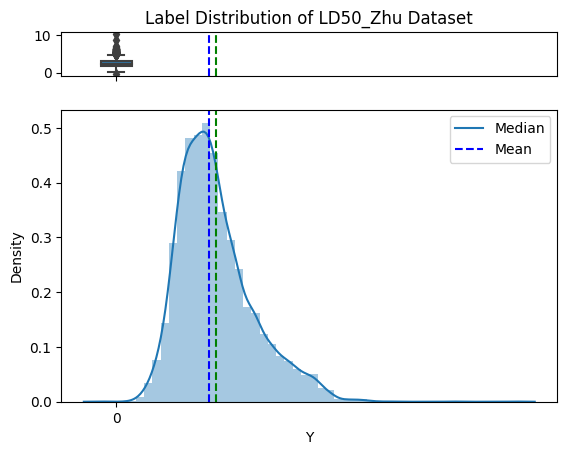

Found local copy...
Loading...
Done!


train: 5170 | valid: 738 | test: 1477 | total: 7385
train min max:  -0.3429999999999999 10.207
Valid min max:  0.58 6.032
test  min max:  0.691 6.515
scaling train valid test data set for regression task 
min, max value for all data: {'LD50_Zhu': [-0.3429999999999999, 10.207]}




********************************************************************************
****************************** CYP2C19_Veith ******************************
********************************************************************************


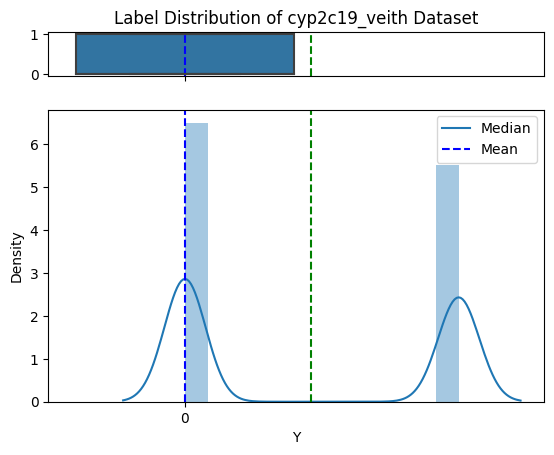

Found local copy...
Loading...
Done!


train: 8866 | valid: 1266 | test: 2533 | total: 12665
******************** total ********************
CYP2C19_Veith 	 0: 6846 | 1: 5819 | total: 12665
******************** train ********************
CYP2C19_Veith 	 0: 4803 | 1: 4063 | total: 8866
******************** valid ********************
CYP2C19_Veith 	 0: 673 | 1: 593 | total: 1266
******************** test ********************
CYP2C19_Veith 	 0: 1370 | 1: 1163 | total: 2533




********************************************************************************
****************************** CYP2D6_Veith ******************************
********************************************************************************


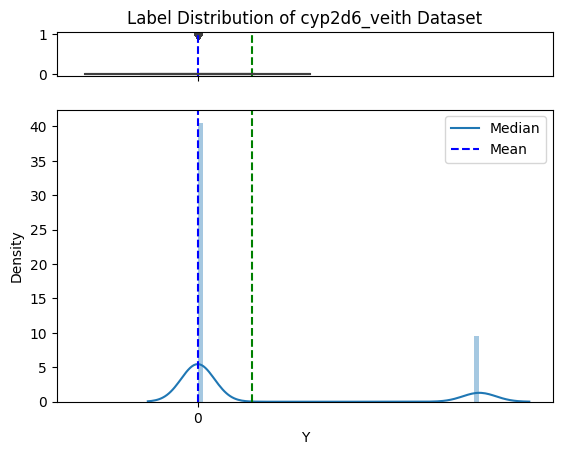

Found local copy...
Loading...
Done!


train: 9191 | valid: 1313 | test: 2626 | total: 13130
******************** total ********************
CYP2D6_Veith 	 0: 10616 | 1: 2514 | total: 13130
******************** train ********************
CYP2D6_Veith 	 0: 7425 | 1: 1766 | total: 9191
******************** valid ********************
CYP2D6_Veith 	 0: 1053 | 1: 260 | total: 1313
******************** test ********************
CYP2D6_Veith 	 0: 2138 | 1: 488 | total: 2626




********************************************************************************
****************************** CYP3A4_Veith ******************************
********************************************************************************


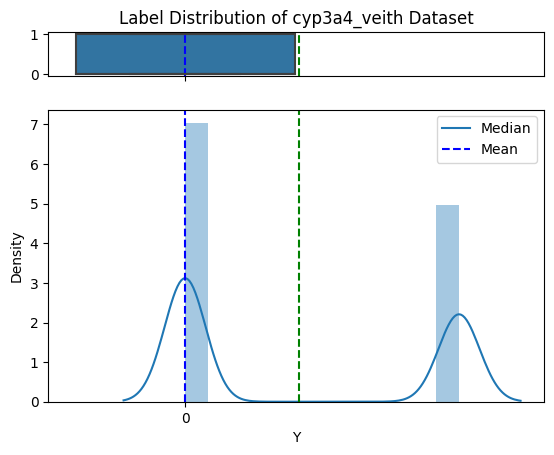

Found local copy...
Loading...
Done!


train: 8629 | valid: 1233 | test: 2466 | total: 12328
******************** total ********************
CYP3A4_Veith 	 0: 7218 | 1: 5110 | total: 12328
******************** train ********************
CYP3A4_Veith 	 0: 5052 | 1: 3577 | total: 8629
******************** valid ********************
CYP3A4_Veith 	 0: 717 | 1: 516 | total: 1233
******************** test ********************
CYP3A4_Veith 	 0: 1449 | 1: 1017 | total: 2466




********************************************************************************
****************************** CYP1A2_Veith ******************************
********************************************************************************


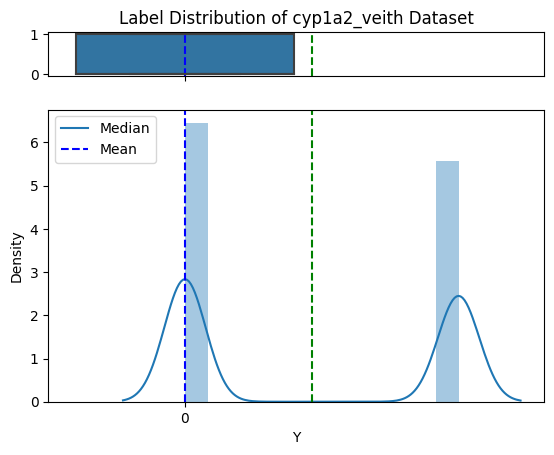

Found local copy...
Loading...
Done!


train: 8805 | valid: 1258 | test: 2516 | total: 12579
******************** total ********************
CYP1A2_Veith 	 0: 6750 | 1: 5829 | total: 12579
******************** train ********************
CYP1A2_Veith 	 0: 4745 | 1: 4060 | total: 8805
******************** valid ********************
CYP1A2_Veith 	 0: 677 | 1: 581 | total: 1258
******************** test ********************
CYP1A2_Veith 	 0: 1328 | 1: 1188 | total: 2516




********************************************************************************
****************************** CYP2C9_Veith ******************************
********************************************************************************


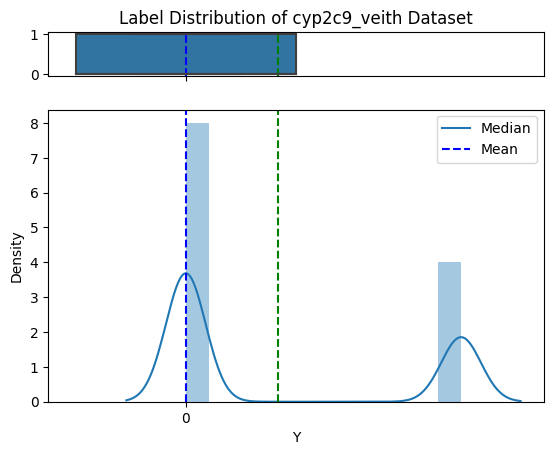

Found local copy...
Loading...
Done!


train: 8465 | valid: 1209 | test: 2418 | total: 12092
******************** total ********************
CYP2C9_Veith 	 0: 8047 | 1: 4045 | total: 12092
******************** train ********************
CYP2C9_Veith 	 0: 5652 | 1: 2813 | total: 8465
******************** valid ********************
CYP2C9_Veith 	 0: 796 | 1: 413 | total: 1209
******************** test ********************
CYP2C9_Veith 	 0: 1599 | 1: 819 | total: 2418




********************************************************************************
****************************** BBB_Martins ******************************
********************************************************************************


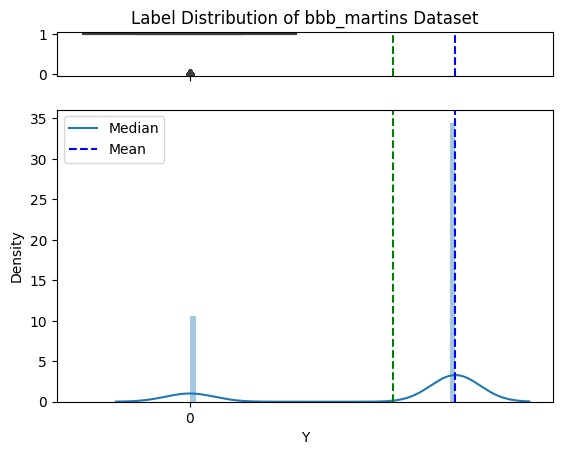

Found local copy...
Loading...
Done!


train: 1421 | valid: 203 | test: 406 | total: 2030
******************** total ********************
BBB_Martins 	 0: 479 | 1: 1551 | total: 2030
******************** train ********************
BBB_Martins 	 0: 325 | 1: 1096 | total: 1421
******************** valid ********************
BBB_Martins 	 0: 51 | 1: 152 | total: 203
******************** test ********************
BBB_Martins 	 0: 103 | 1: 303 | total: 406




********************************************************************************
****************************** Bioavailability_Ma ******************************
********************************************************************************


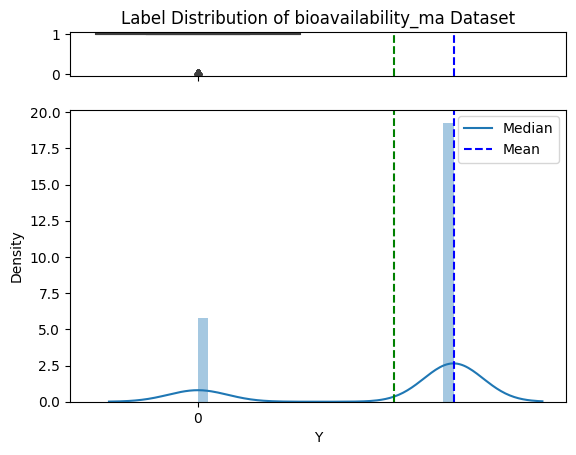

Found local copy...
Loading...
Done!


train: 448 | valid: 64 | test: 128 | total: 640
******************** total ********************
Bioavailability_Ma 	 0: 148 | 1: 492 | total: 640
******************** train ********************
Bioavailability_Ma 	 0: 97 | 1: 351 | total: 448
******************** valid ********************
Bioavailability_Ma 	 0: 13 | 1: 51 | total: 64
******************** test ********************
Bioavailability_Ma 	 0: 38 | 1: 90 | total: 128




********************************************************************************
****************************** Pgp_Broccatelli ******************************
********************************************************************************


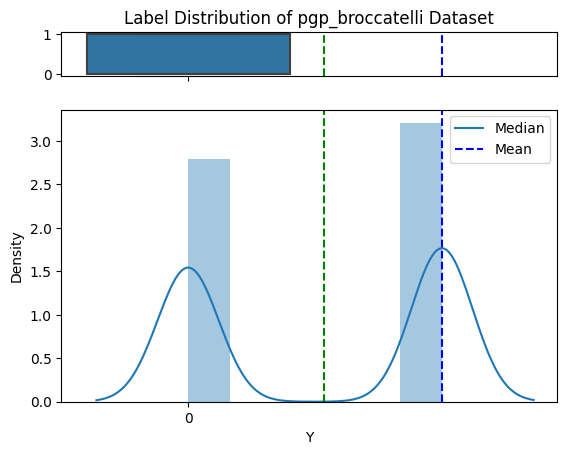

Found local copy...
Loading...
Done!


train: 852 | valid: 122 | test: 244 | total: 1218
******************** total ********************
Pgp_Broccatelli 	 0: 568 | 1: 650 | total: 1218
******************** train ********************
Pgp_Broccatelli 	 0: 391 | 1: 461 | total: 852
******************** valid ********************
Pgp_Broccatelli 	 0: 56 | 1: 66 | total: 122
******************** test ********************
Pgp_Broccatelli 	 0: 121 | 1: 123 | total: 244




********************************************************************************
****************************** HIA_Hou ******************************
********************************************************************************


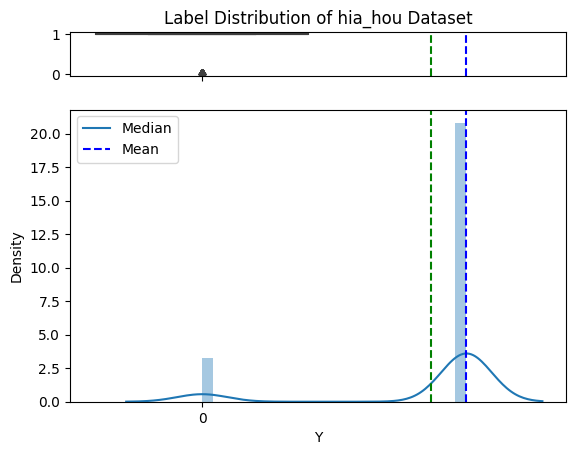

Found local copy...
Loading...
Done!


train: 404 | valid: 58 | test: 116 | total: 578
******************** total ********************
HIA_Hou 	 0: 78 | 1: 500 | total: 578
******************** train ********************
HIA_Hou 	 0: 53 | 1: 351 | total: 404
******************** valid ********************
HIA_Hou 	 0: 6 | 1: 52 | total: 58
******************** test ********************
HIA_Hou 	 0: 19 | 1: 97 | total: 116




********************************************************************************
****************************** PAMPA_NCATS ******************************
********************************************************************************


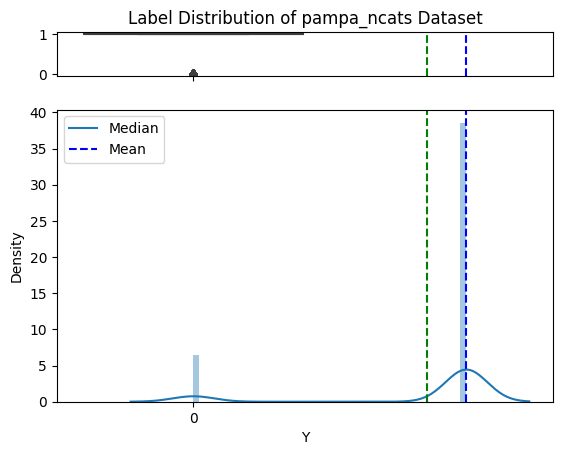

Found local copy...
Loading...
Done!


train: 1424 | valid: 203 | test: 407 | total: 2034
******************** total ********************
PAMPA_NCATS 	 0: 295 | 1: 1739 | total: 2034
******************** train ********************
PAMPA_NCATS 	 0: 199 | 1: 1225 | total: 1424
******************** valid ********************
PAMPA_NCATS 	 0: 33 | 1: 170 | total: 203
******************** test ********************
PAMPA_NCATS 	 0: 63 | 1: 344 | total: 407




********************************************************************************
****************************** hERG_Karim ******************************
********************************************************************************


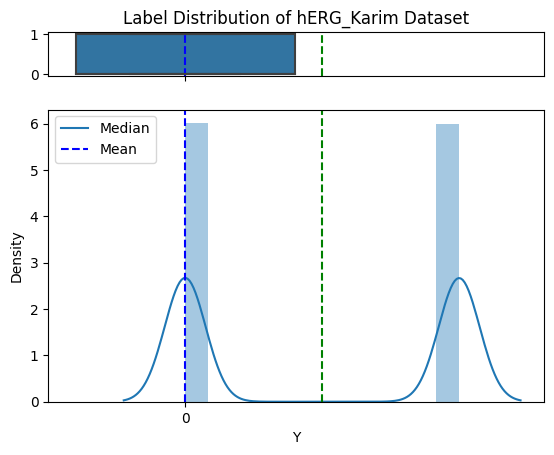

Found local copy...
Loading...
Done!


train: 9412 | valid: 1344 | test: 2689 | total: 13445
******************** total ********************
hERG_Karim 	 0: 6727 | 1: 6718 | total: 13445
******************** train ********************
hERG_Karim 	 0: 4698 | 1: 4714 | total: 9412
******************** valid ********************
hERG_Karim 	 0: 683 | 1: 661 | total: 1344
******************** test ********************
hERG_Karim 	 0: 1346 | 1: 1343 | total: 2689




********************************************************************************
****************************** AMES ******************************
********************************************************************************


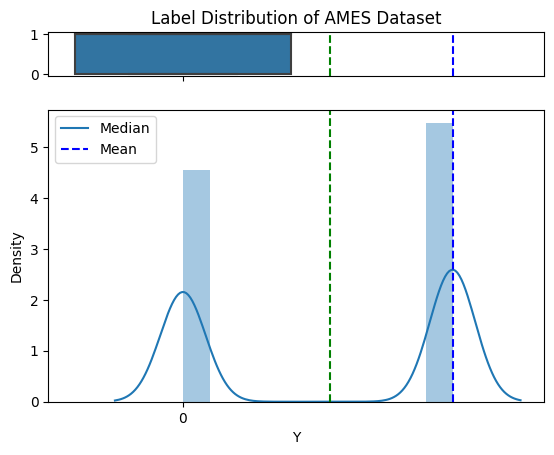

train: 5094 | valid: 728 | test: 1456 | total: 7278
******************** total ********************
AMES 	 0: 3304 | 1: 3974 | total: 7278
******************** train ********************
AMES 	 0: 2335 | 1: 2759 | total: 5094
******************** valid ********************
AMES 	 0: 311 | 1: 417 | total: 728
******************** test ********************
AMES 	 0: 658 | 1: 798 | total: 1456






In [ ]:
for name, task_type in names_dict.items():
    print('*'*80)
    print('*'*30, name, '*'*30)
    print('*'*80)
    trains, valids, tests = collect_data_10_24([name])
    df_all   = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
    print(f'train: {len(trains)} | valid: {len(valids)} | test: {len(tests)} | '
          f'total: {len(trains) + len(valids) + len(tests)}')
    if task_type == False: # classification
        print('*'*20, 'total', '*'*20)
        count_(df_all)
        print('*'*20, 'train', '*'*20)
        count_(trains)
        print('*'*20, 'valid', '*'*20)
        count_(valids)
        print('*'*20, 'test', '*'*20)
        count_(tests)
    if task_type == True: # regression
        print('train min max: ', trains[name].min(), trains[name].max())
        print('Valid min max: ', valids[name].min(), valids[name].max())
        print('test  min max: ', tests[name].min(),  tests[name].max())
        _, _, _, scale_dict = scale(trains, valids, tests)
        print('min, max value for all data:', scale_dict)
    print('\n\n\n')

## PCA and t-SNE analysis

The following code will create 2 folders PCA/ and t-SNE/

Check folder for PCA and t-SNE plots

for each task, there are:

    4 PCA   plots: train set, valid set, test set and data set, in which data set is the sum of train,valid,test

    4 t-SNE plots: similarly

In [ ]:
"""Plot PCA, t-SNE for dataset on all tasks"""
for name, IS_R in names_dict.items():
    # if IS_R == False: # classification task
    trains, valids, tests = collect_data_10_24([name], show_dist=False)
    df_all   = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
    data_list = [trains, valids, tests, df_all]
    desc_list = ['train set', 'valid set', 'test set', 'data set']
    for (data, desc) in zip(data_list, desc_list):
        data = process(data)
        features, labels = data[header], data[name]
        assert features.shape[0] == len(labels)
        for dim_reduct in ['PCA', 't-SNE']:
            title = f'{dim_reduct} on {desc} of {name}'
            # if dim_reduct == 'PCA':
            plot_dim_reduced(features, labels, IS_R, dim_reduct, title)


In [ ]:
from tqdm import tqdm
from PIL import Image

names_all = list(names_dict.keys())
desc_list = ['train set', 'valid set', 'test set', 'data set']
reduction = ['PCA', 't-SNE']

"""For single plot, set the width and height"""
width = 8
heigh = 6

names_plot = names_all

fig, axes = plt.subplots(len(names_plot), len(desc_list),
                         figsize=(width*len(desc_list),
                                  heigh*len(names_plot))) #(w,h))

for i, name in tqdm(enumerate(names_plot), total=len(names_plot)):
    for j, desc in enumerate(desc_list):
    # for dim_reduct in reduction:
        dim_reduct = 'PCA'
        ax = axes[i, j]
        title = f'{dim_reduct} on {desc} of {name}'
        img_path = f'{dim_reduct}/{title}.png'
        image = Image.open(img_path)
        # ax.imshow(image)
        ax.axis('off'); ax.imshow(image)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
make_path('GRID_GRAPHS', False)
plt.savefig(f'GRID_GRAPHS/demo.png', format='png', transparent=True)
plt.show(); plt.close()
# plt.subplots_adjust(bottom=.01)

In [ ]:
"""Plot stacked grid image for PCA t-SNE for a specific task"""

names_plot = names_all

for name in tqdm(names_plot, total=len(names_plot)):
    fig, axes = plt.subplots(len(reduction), len(desc_list),
    figsize=(width*len(desc_list), heigh*len(reduction))) #(w,h))
    for i, dim_reduct in enumerate(reduction):
        for j, desc in enumerate(desc_list):
            ax = axes[i, j]
            title = f'{dim_reduct} on {desc} of {name}'
            img_path = f'{dim_reduct}/{title}.png'
            image = Image.open(img_path)
            ax.axis('off'); ax.imshow(image)

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    make_path('GRID_GRAPHS', False)
    save_dir = f'GRID_GRAPHS/{name}_PCA_TSNE.png'
    plt.savefig(save_dir, dpi=400, format='png', transparent=True)
    print('save fig at', save_dir)
    plt.show(); plt.close()


In [13]:
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

def pairwise_similarity(fp_list):
    num = len(fp_list)
    similarities = np.zeros((num, num))
    for i in range(num):
        similarity = DataStructs.BulkTanimotoSimilarity(
            fp_list[i], fp_list[i:])
        # print(type(similarity), len(similarity))
        similarities[i, i:] = similarity
        similarities[i:, i] = similarity
    for i in range(num): assert similarities[i, i] == 1
    return similarities

def plot_tanimoto(df, title=None, savepath=None):
    smiles = df['Drug']
    maccs_list = []
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        maccs = MACCSkeys.GenMACCSKeys(mol)
        maccs_list.append(maccs)
    similarities = pairwise_similarity(maccs_list)
    fig = plt.figure(figsize = (8,8))
    heatmap = sns.heatmap(similarities, cmap='Blues', square=True)
    # Get the color bar axes and adjust its position and size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_aspect(20)  # Adjust this value as needed to match the figure size

    # Adjust the color bar's position and size
    cax = plt.gcf().axes[-1]
    cax.set_position([0.78, 0.1, 0.03, 0.8])  # Adjust these values as needed

    if title == None: title = 'Tanimoto Demo'
    plt.title(title, fontsize = 16)
    make_path('Tanimoto', False)
    if savepath == None: savepath = f'Tanimoto/{title}.png'
    plt.savefig(savepath, format='png', transparent=True)
    print('figure saved at ', savepath)
    plt.show(); plt.close()

# plot_tanimoto(valids)

In [ ]:
"""Tanimoto Similarity Calculation"""

names_all = list(names_dict.keys())

for name in tqdm(names_all, total=len(names_all)):
    # if IS_R == False: # classification task
    trains, valids, tests = collect_data_10_24([name], show_dist=False)
    df_all   = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
    data_list = [trains, valids, tests, df_all]
    desc_list = ['train set', 'valid set', 'test set', 'data set']
    for (data, desc) in zip(data_list, desc_list):
        title = f'Tanimoto on {desc} of {name}'
        plot_tanimoto(data, title)


In [ ]:
from tqdm import tqdm
from PIL import Image
"""Plot stacked grid image for Tanimoto for a specific task"""

names_plot = names_all
"""For single plot, set the width and height"""
width = 10
heigh = 18
for name in tqdm(names_plot, total=len(names_plot), desc=f'# task {name}'):
    fig, axes = plt.subplots(1, len(desc_list),
    figsize=(width*len(desc_list), heigh*1)) #(w,h))

    # print(axes)
    for j, desc in enumerate(desc_list):
        ax = axes[j]
        title = f'Tanimoto on {desc} of {name}'
        img_path = f'Tanimoto/{title}.png'
        image = Image.open(img_path)
        ax.axis('off'); ax.imshow(image)
    # plt.subplots_adjust(wspace=0.01)
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.18, hspace=-0.01)
    make_path('GRID_GRAPHS', False)
    save_dir = f'GRID_GRAPHS/{name}_Tanimoto.png'
    plt.savefig(save_dir, dpi=400, format='png', transparent=True)
    print('save fig at', save_dir)
    plt.show(); plt.close()

